In [6]:
import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import csv
import time
from pypylon import pylon
import cv2
import cProfile, pstats, io
import copy

In [7]:
date = ""
month = ""
datemonth = date + "_" + month

In [8]:
def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

shape is:  (512, 512)
dataWidth = 1920
dataHeight = 1080
[[0.         3.14159265 3.14159265 ... 0.         3.14159265 3.14159265]
 [3.14159265 0.         3.14159265 ... 3.14159265 0.         3.14159265]
 [3.14159265 3.14159265 3.14159265 ... 0.         3.14159265 0.        ]
 ...
 [3.14159265 3.14159265 0.         ... 3.14159265 3.14159265 0.        ]
 [0.         3.14159265 0.         ... 0.         0.         0.        ]
 [3.14159265 0.         0.         ... 0.         3.14159265 3.14159265]]
(1024, 1024)


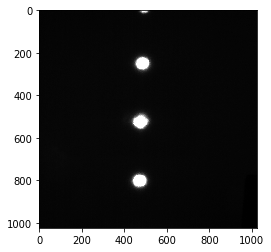

In [25]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#new_width = camera.Width.GetValue() - camera.Width.GetInc()
#if new_width >= camera.Width.GetMin():
#    camera.Width.SetValue(new_width)

#camera.OffsetX.SetValue(600)
#camera.OffsetY.SetValue(0)
#camera.Width.SetValue(2048-600)
#camera.Height.SetValue(1088-88)

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)


# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
#data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)

#data = slmdisplaysdk.createFieldUChar(128,128)
#data = slmdisplaysdk.createFieldUChar(256,256)
data = slmdisplaysdk.createFieldUChar(512,512)
size = data.shape
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = np.pi*(np.sign(np.random.normal(0,1,size)+1e-7) + 1)/2
print(data)
error = slm.showPhasevalues(data)

#Change Threshold

Threshold = 1

def cost(I_target, I_camera):
    return np.sum((I_target-I_camera)**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this, and resize probably
TargetIntensity = np.load("target16_10.npy")
#TargetIntensity = np.load('targetMC_' + datemonth + '.npy')
#TargetIntensity[0:1080, 0:400] = 0 # Remove background light
#TargetIntensity[460:500, 495:535] = 0
print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.show()

def flip(phasevalues, shape, d):
    y = copy.copy(phasevalues)
    a = np.random.randint(0,shape[0],d)
    b = np.random.randint(0,shape[1],d)
    #print(a,b)
    y[a, b] = np.pi-y[a, b]
    return y

In [10]:
def grating(shape):
    mask = np.zeros(shape)
    
    idx = [2*i for i in range(shape[0]//2)]
    mask[idx,:]=128
    
    return mask

#data = np.pi*grating(size)/128

#for i in range(10):
    #data = flip(data, size, 50)

In [33]:
@profile
def loopfunc(number, data, Threshold):
    numberOfImagesToGrab = number
    count = 0
    
    prev_img = TargetIntensity
    COST = []
    difference = []
    COST.append(100)
    area = size[0]*size[1]
    d = 2**6
    
    time_start = time.time()
    
    while count in range(numberOfImagesToGrab) and (COST[-1] > Threshold) and (d < area):
        data2 = flip(data, size, d)
        #print(np.sum(abs(data2-data)))
        #data2 = np.pi*grating(size)/128
        error = slm.showPhasevalues(data2)
        #input("Press a key...")
        time.sleep(0.2)
        #error = slm.showPhasevalues(data)
          
        camera.StartGrabbingMax(1)
        
        while camera.IsGrabbing():
            grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
            
            if grabResult.GrabSucceeded():
                
                # Access the image data.
                img = grabResult.Array #.reshape((grabResult.Height, grabResult.Width))
                
            else:
                print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
            grabResult.Release()
            
               
        #img_sliced = img[4:1084, 64:1984]
        
        #img_sliced[0:1080, 0:336]=0
       
              
        #cv2.imwrite('with_phase_06_10/with_phase'+ str(iter) + '.png', I)
        
        #img[460:500, 495:535] = 0 # SETTING CENTRAL BRIGHT SPOT TO ZERO TO REMOVE IT FROM INFLUENCING THE COST FUNCTION
        difference.append(cost(prev_img, img))
        prev_img = img
        C1 = cost(TargetIntensity, img)
        #COST.append(cost(TargetIntensity,img))
        #plt.imshow(img, cmap='gray')
        #print(COST[-1])
                
        #print(C1)
        if C1 < COST[-1]:
            data=data2
            COST.append(C1)
        else:
            data=data
            
            COST.append(COST[-1])
            #d *= 2
                  
        count += 1
        if (count%400) == 0:
            d *= 2
        else:
            d = d
        #d *= 2*((count%400)//399)
        
    
    time_end = time.time()
    print(data.shape)
    print("TIME: ", time_end-time_start)
    print("Converged in ", count , " iterations")
    return data, COST, difference

data_end = loopfunc(4000, data_end[0], Threshold)

(512, 512)
TIME:  1592.2948741912842
Converged in  4000  iterations
         256172 function calls (252172 primitive calls) in 1592.299 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    8.532    8.532 1592.299 1592.299 <ipython-input-33-193a44031949>:1(loopfunc)
     4000  800.599    0.200  800.599    0.200 {built-in method time.sleep}
     4000    0.094    0.000  243.775    0.061 C:\Users\Ramesh\Downloads\anaconda\lib\site-packages\pypylon\pylon.py:3393(RetrieveResult)
     4000  243.440    0.061  243.680    0.061 {built-in method pypylon._pylon.InstantCamera_RetrieveResult}
     4000  178.346    0.045  178.879    0.045 C:\Program Files\HOLOEYE Photonics\SLM Display SDK (Python) v2.0.1\python\holoeye\slmdisplaysdk\__init__.py:804(showPhasevalues)
     8000  134.993    0.017  177.073    0.022 <ipython-input-25-ab3dea53b710>:58(cost)
     4000    0.151    0.000   95.804    0.024 C:\Users\Ramesh\Downloads\anacond

In [24]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None

AssertionError: b'The SLM could not be initialized or was disconnected.'

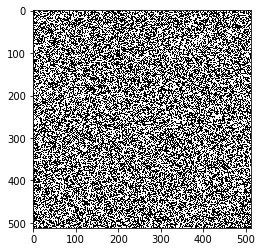

In [27]:
plt.imshow(data_end[0], cmap='gray')

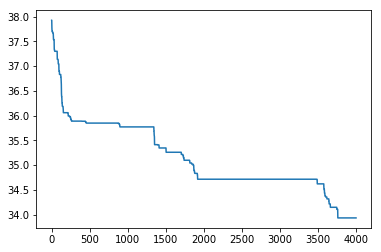

In [28]:
plt.plot(data_end[1][1:])
#print(len(data_end[1]))
#print(data_end[1])

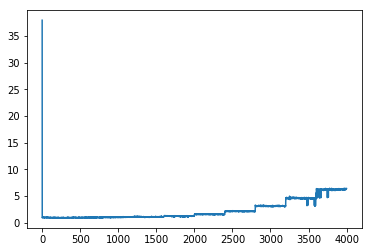

In [29]:
plt.plot(data_end[2])

In [15]:
# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)


# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
#data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)

data = slmdisplaysdk.createFieldUChar(256,256)
size = data.shape
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
#data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data = np.pi*(np.sign(np.random.normal(0,1,size)+1e-7) + 1)/2
print(data)
error = slm.showPhasevalues(data)


shape is:  (256, 256)
dataWidth = 1920
dataHeight = 1080
[[0.         3.14159265 0.         ... 3.14159265 0.         3.14159265]
 [0.         0.         3.14159265 ... 3.14159265 3.14159265 3.14159265]
 [0.         0.         3.14159265 ... 0.         3.14159265 3.14159265]
 ...
 [3.14159265 0.         0.         ... 3.14159265 0.         0.        ]
 [0.         3.14159265 0.         ... 3.14159265 0.         0.        ]
 [0.         3.14159265 3.14159265 ... 0.         0.         0.        ]]


In [27]:
slm.close()
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
slm = None

AssertionError: b'The SLM could not be initialized or was disconnected.'

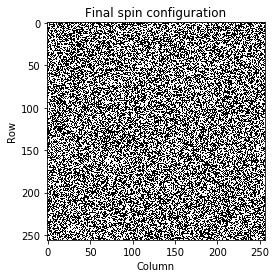

In [43]:
plt.imshow(data_end[0], cmap='gray')
plt.xlabel("Column")
plt.ylabel("Row")
plt.title("Final spin configuration")
plt.savefig("MC_spin_14_10.png")

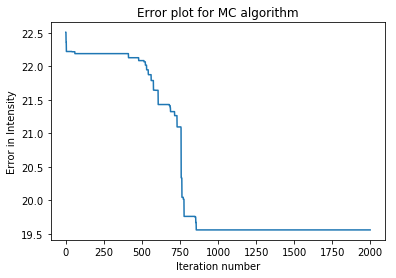

In [44]:
plt.plot(data_end[1][1:])
plt.xlabel("Iteration number")
plt.ylabel("Error in Intensity")
plt.title("Error plot for MC algorithm")
plt.savefig("error_15_10.png")
#print(len(data_end[1]))
#print(data_end[1])

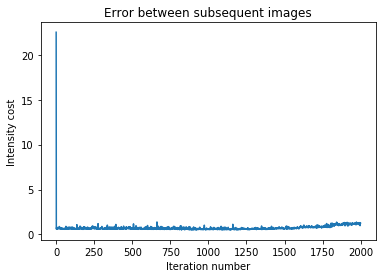

In [45]:
plt.plot(data_end[2])
plt.xlabel("Iteration number")
plt.ylabel("Intensity cost")
plt.title("Error between subsequent images")
plt.savefig("subsequent_14_10.png")

In [46]:
np.save("MC_data_14_10", data_end)
A = np.load("MC_data_14_10.npy")
print(A)

[array([[3.14159265, 0.        , 3.14159265, ..., 0.        , 3.14159265,
        0.        ],
       [0.        , 3.14159265, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.14159265, 3.14159265, 0.        , ..., 3.14159265, 3.14159265,
        3.14159265],
       ...,
       [3.14159265, 3.14159265, 0.        , ..., 3.14159265, 0.        ,
        0.        ],
       [3.14159265, 3.14159265, 0.        , ..., 0.        , 3.14159265,
        0.        ],
       [0.        , 3.14159265, 0.        , ..., 3.14159265, 0.        ,
        0.        ]])
 list([999999999999999999, 22.51075138121547, 22.51075138121547, 22.364332872928177, 22.364332872928177, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.223168508287294, 22.22316850828729

In [31]:
camera.Close()

In [5]:
# CHECKING THE FLIP FUNCTION


import numpy as np
import copy 

a = np.random.randint(0,512,64)
b = np.random.randint(0,512,64)
print(a.shape)
print(b.shape)
phasevalues = np.zeros((512,512))
y = copy.copy(phasevalues)
print(y.shape)
print(np.sum(y))
y[a,b] = 1 - y[a,b]

print(np.sum(y))

(64,)
(64,)
(512, 512)
0.0
64.0


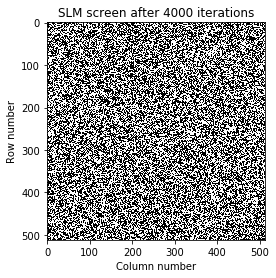

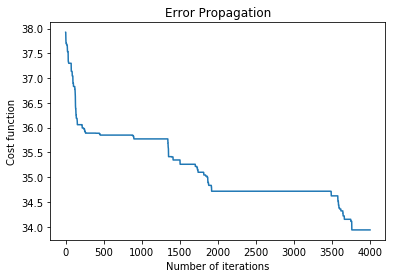

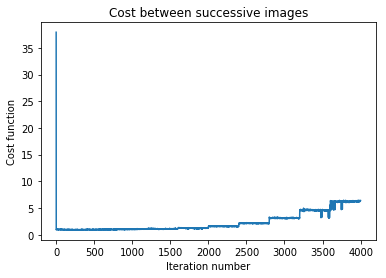

In [30]:
plt.imshow(data_end[0], cmap='gray')
plt.xlabel("Column number")
plt.ylabel("Row number")
plt.title("SLM screen after 4000 iterations")
plt.show()

plt.plot(data_end[1][1:])
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Error Propagation")
plt.show()

plt.plot(data_end[2])
plt.xlabel("Iteration number")
plt.ylabel("Cost function")
plt.title("Cost between successive images")
plt.show()

In [32]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

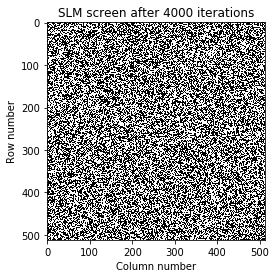

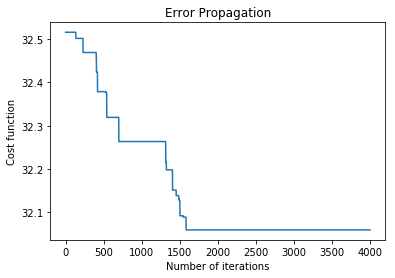

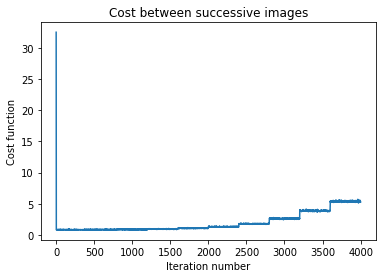

In [34]:
plt.imshow(data_end[0], cmap='gray')
plt.xlabel("Column number")
plt.ylabel("Row number")
plt.title("SLM screen after 4000 iterations")
plt.show()

plt.plot(data_end[1][1:])
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Error Propagation")
plt.show()

plt.plot(data_end[2])
plt.xlabel("Iteration number")
plt.ylabel("Cost function")
plt.title("Cost between successive images")
plt.show()